## Part 1 - Problem Framing

### 1. What is the real business problem?
The core business problem is declining conversion efficiency. Although pipeline volume appears healthy, fewer deals are converting into wins.

More importantly, the CRO lacks clarity on what is driving the decline in win rate. Without understanding whether the issue is related to a  specific industry, region performance, sales execution, deal stage dynamics, or deal size, leadership cannot take targeted corrective action.

This is fundamentally a diagnostic decision-intelligence problem.


### 2. What key questions should an AI system answer for the CRO?

The AI system should help answer:

#### Diagnostic Questions (What is happening?)
* Has win rate declined uniformly, or is it concentrated in specific industries, regions, or sales reps?

* Is the decline associated with particular deal sizes?

* Are more deals being lost at earlier stages (e.g., Demo or Proposal)?

* Has the distribution of deals across stages changed compared to previous quarters?


#### Causal Questions (Why is it happening?)
* Has pipeline composition shifted toward lower-converting industries or segments?

* Are certain sales reps underperforming relative to historical benchmarks?

* Are smaller or larger deals converting at different rates than before?

#### Prescriptive Questions (What should we do?)
* Which segments should leadership prioritize?

* Which deal characteristics are associated with higher win probability?


### 3. What metrics matter most for diagnosing win rate issues?

Since all deals are closed in this dataset:

Core Metric : Win Rate=Won/Total Deals

Segmented Win Rates

* Win rate by industry

* Win rate by region

* Win rate by sales rep

* Win rate by deal size

* Win rate by stage

Supporting Metrics

* Average deal size (Won vs Lost)

* Changes in segment mix across time periods


These metrics allow decomposition of win rate decline to identify structural drivers.


### 4. What assumptions are being made?
* All deals in the dataset are finalized (Won or Lost).

* Stage represents the final active stage before closure.

* Win rate decline is statistically meaningful and not random variation.

* Pipeline volume concerns raised by the CRO reflect perception from broader CRM data, even though this dataset only contains closed deals.

* No qualitative data (e.g., customer feedback) is available.


### Please
- Run Part 2 for EDA and Insights and
- Run Part 3 for Decision Engine

## Part 2 : Exploratory Data Analysis

In [110]:
import pandas as pd
df = pd.read_csv('/content/skygeni_sales_data.csv')

### 1. Data Sanity Check

In [111]:
# Sample Data
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [112]:
# General shape of the data
df.shape

(5000, 12)

In [113]:
#Type of deal stage
df['deal_stage'].unique()

array(['Qualified', 'Closed', 'Proposal', 'Negotiation', 'Demo'],
      dtype=object)

In [114]:
#Outcome Type
df['outcome'].unique()

array(['Won', 'Lost'], dtype=object)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB


In [116]:
#Checking missing / null values
df.isnull().sum()

,0
deal_id,0
created_date,0
closed_date,0
sales_rep_id,0
industry,0
region,0
product_type,0
lead_source,0
deal_stage,0
deal_amount,0


In [117]:
# Duplicate rows
df.duplicated().sum()

np.int64(0)

In [118]:
#Win Rate
win_rate = (df['outcome'] == 'Won').mean() * 100
print("Overall Win Rate:", round(win_rate, 2), "%")

Overall Win Rate: 45.26 %


### 2. Business EDA

The objective of this analysis is to understand the drivers behind the recent decline in win rate between 2024Q1 and 2024Q2. Since the dataset contains finalized deals (Won/Lost), the focus is on identifying structural shifts in conversion efficiency across segments such as industry, product type, region, and deal stage.

In [119]:
df.head()

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [120]:
#Converting closed date to datetime
df['closed_date'] = pd.to_datetime(df['closed_date'])

In [121]:
#Deriving feature year_quarter from closed date
df['year_quarter'] = df['closed_date'].dt.to_period('Q')

In [122]:
#Quarterly Win Rate analysis
quarter_win_rate = (
    df.groupby('year_quarter')
    .agg(
        total_deals=('outcome', 'count'),
        won_deals=('outcome', lambda x: (x == 'Won').sum())
    )
    .reset_index()
)

quarter_win_rate['win_rate'] = (
    quarter_win_rate['won_deals'] / quarter_win_rate['total_deals']
)

print(quarter_win_rate)

  year_quarter  total_deals  won_deals  win_rate
0       2023Q1          328        146  0.445122
1       2023Q2          973        438  0.450154
2       2023Q3         1016        435  0.428150
3       2023Q4         1027        488  0.475170
4       2024Q1          990        462  0.466667
5       2024Q2          637        279  0.437991
6       2024Q3           29         15  0.517241


In [123]:
#Inspecting 2024Q3
df['closed_date'].describe()

,closed_date
count,5000
mean,2023-10-17 00:13:32.160000
min,2023-01-11 00:00:00
25%,2023-06-26 00:00:00
50%,2023-10-15 00:00:00
75%,2024-02-08 00:00:00
max,2024-07-20 00:00:00


In [124]:
#Excluding 2024Q3 from the analysis, due to incomplete data for the quarter
df_quarter_analysis = df[~df['year_quarter'].astype(str).isin(['2024Q3'])]

In [125]:
#Recomputing the win rate for the selected quarters
quarter_win_rate = (
    df_quarter_analysis.groupby('year_quarter')
    .agg(
        total_deals=('outcome', 'count'),
        won_deals=('outcome', lambda x: (x == 'Won').sum())
    )
    .reset_index()
)

quarter_win_rate['win_rate'] = (
    quarter_win_rate['won_deals'] / quarter_win_rate['total_deals']
)

print(quarter_win_rate)

  year_quarter  total_deals  won_deals  win_rate
0       2023Q1          328        146  0.445122
1       2023Q2          973        438  0.450154
2       2023Q3         1016        435  0.428150
3       2023Q4         1027        488  0.475170
4       2024Q1          990        462  0.466667
5       2024Q2          637        279  0.437991


In [126]:
#Year Quarter to string for plotting
quarter_win_rate['year_quarter_str'] = quarter_win_rate['year_quarter'].astype(str)

#### EDA - Win Rate and Deal Volumne by Quarter
- Win rate was calculated as the number of Closed Won deals divided by total closed deals (Won + Lost). Quarterly win rate was computed using deal close date to ensure consistency in period comparison.

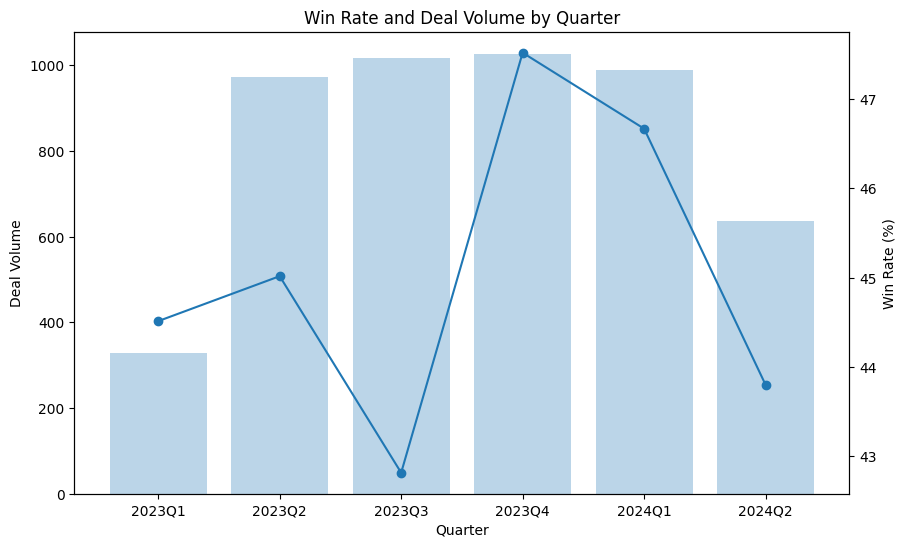

In [127]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for deal volume
ax1.bar(
    quarter_win_rate['year_quarter_str'],
    quarter_win_rate['total_deals'],
    alpha=0.3
)

ax1.set_xlabel("Quarter")
ax1.set_ylabel("Deal Volume")
ax1.tick_params(axis='y')

# Secondary axis for win rate
ax2 = ax1.twinx()

ax2.set_ylabel("Win Rate (%)")
ax2.plot(
    quarter_win_rate['year_quarter_str'],
    quarter_win_rate['win_rate'] * 100,
    marker='o'
)

plt.title("Win Rate and Deal Volume by Quarter")
plt.xticks(rotation=45)

plt.show()


Analysis -

* Win rate fluctuated between 42% and 47% over the past six quarters. While there is a decline from 46% in 2024Q1 to 43% in 2024Q2, overall performance remains within historical volatility range.
* The recent 3 percentage point decline does not indicate a systemic collapse but rather short-term volatility. However, given the drop in closed deal volume from 990 to 637, even modest win rate deterioration may have amplified revenue impact.
* Given the limited magnitude of overall win rate change, deeper analysis was conducted at segment level (industry, product type, and stage) to identify structural drivers hidden within aggregate stability.   



#### 2024Q1 and 2024Q2 Analysis

### 1. Insights - 1

In [128]:
# Filter only Q1 and Q2 2024
df_2024 = df[df['year_quarter'].isin([pd.Period('2024Q1'),
                                       pd.Period('2024Q2')])]

In [129]:
#Function for Macro Quarter Summary
def macro_quarter_summary(df, q1, q2):

    df_filtered = df[df['year_quarter'].isin([q1, q2])].copy()

    summary = (
        df_filtered.groupby('year_quarter')
        .apply(lambda x: pd.Series({
            'total_deals': len(x),
            'won_deals': (x['outcome'] == 'Won').sum(),
            'lost_deals': (x['outcome'] == 'Lost').sum(),
            'total_revenue': x['deal_amount'].sum(),
            'won_revenue': x.loc[x['outcome'] == 'Won', 'deal_amount'].sum(),
            'lost_revenue': x.loc[x['outcome'] == 'Lost', 'deal_amount'].sum(),
            'avg_deal_size': x['deal_amount'].mean()
        }))
        .reset_index(drop=False)
    )

    summary['win_rate'] = summary['won_deals'] / summary['total_deals']

    summary = summary.sort_values('year_quarter').reset_index(drop=True)

    for col in ['total_deals', 'total_revenue', 'won_revenue',
                'lost_revenue', 'avg_deal_size', 'win_rate']:

        summary[f'{col}_pct_change'] = summary[col].pct_change()

    return summary


In [130]:
q1 = pd.Period('2024Q1')
q2 = pd.Period('2024Q2')

macro_summary = macro_quarter_summary(df, q1, q2)

/tmp/ipython-input-1747859526.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


In [131]:
print(macro_summary)

  year_quarter  total_deals  won_deals  lost_deals  total_revenue  \
0       2024Q1        990.0      462.0       528.0     26413879.0   
1       2024Q2        637.0      279.0       358.0     17009398.0   

   won_revenue  lost_revenue  avg_deal_size  win_rate  total_deals_pct_change  \
0   12702445.0    13711434.0   26680.685859  0.466667                     NaN   
1    7518918.0     9490480.0   26702.351648  0.437991               -0.356566   

   total_revenue_pct_change  won_revenue_pct_change  lost_revenue_pct_change  \
0                       NaN                     NaN                      NaN   
1                 -0.356043               -0.408073                -0.307842   

   avg_deal_size_pct_change  win_rate_pct_change  
0                       NaN                  NaN  
1                  0.000812            -0.061449  


#### Insight 1 — Revenue Decline Driven by Lower Deal Closures
Finding:

Between 2024Q1 and 2024Q2, closed deal volume declined by 36%, resulting in a similar 36% drop in total closed revenue. Won revenue declined more sharply (−41%), while average deal size remained stable.

Why It Matters:

The revenue contraction is primarily driven by fewer deals being closed rather than smaller deal sizes. Additionally, the sharper decline in won revenue compared to total revenue indicates reduced successful conversions within the closed pipeline.

Action:

Focus on improving deal closure effectiveness and reviewing why fewer deals are being successfully converted in Q2.

### 2. Insights - 2

🔹 Custom Metrics Used in Segment Analysis

To understand which segments materially contributed to the overall win rate decline, the following metrics were introduced:

1️⃣ Win Rate Change

The difference in win rate between Q2 and Q1 for a given segment.
It measures how conversion performance shifted quarter-over-quarter.

2️⃣ Deal Share (Q2)

The proportion of total Q2 deals contributed by each segment.
It reflects the relative size and business exposure of that segment.

3️⃣ Segment Impact Score (Custom Metric)

Defined as:

Win Rate Change × Deal Share (Q2)

This metric weights conversion deterioration by business size, helping identify which segments meaningfully influenced overall performance.

Segments with:

Large deal share

Significant win rate decline

Will have the largest negative impact.

In [132]:
def segment_conversion_insight(df, segment_col, q1, q2):

    # Filter quarters
    df_filtered = df[df['year_quarter'].isin([q1, q2])].copy()

    # Aggregate metrics
    grouped = (
        df_filtered.groupby(['year_quarter', segment_col])
        .agg(
            total_deals=('outcome', 'count'),
            won_deals=('outcome', lambda x: (x == 'Won').sum())
        )
        .reset_index()
    )

    # Compute win rate
    grouped['win_rate'] = grouped['won_deals'] / grouped['total_deals']

    # Pivot to compare Q1 vs Q2
    pivot = grouped.pivot(index=segment_col,
                          columns='year_quarter')

    # Flatten multiindex columns
    pivot.columns = ['_'.join([str(col[0]), str(col[1])]) for col in pivot.columns]
    pivot = pivot.reset_index()

    # Win rate change
    pivot['win_rate_change'] = (
        pivot[f'win_rate_{q2}'] - pivot[f'win_rate_{q1}']
    )

    # Deal share in Q2
    total_q2_deals = df_filtered[df_filtered['year_quarter'] == q2].shape[0]
    pivot['deal_share_q2'] = (
        pivot[f'total_deals_{q2}'] / total_q2_deals
    )

    # Custom Metric — Segment Impact Score
    pivot['segment_impact_score'] = (
        pivot['win_rate_change'] * pivot['deal_share_q2']
    )

    # Sort by most negative impact
    pivot = pivot.sort_values('segment_impact_score')

    return pivot


In [133]:
q1 = pd.Period('2024Q1')
q2 = pd.Period('2024Q2')

product_conversion = segment_conversion_insight(df, 'product_type', q1, q2)
region_conversion = segment_conversion_insight(df, 'region', q1, q2)

print(product_conversion.head())


  product_type  total_deals_2024Q1  total_deals_2024Q2  won_deals_2024Q1  \
0         Core                 340                 228               169   
2          Pro                 319                 208               149   
1   Enterprise                 331                 201               144   

   won_deals_2024Q2  win_rate_2024Q1  win_rate_2024Q2  win_rate_change  \
0               101         0.497059         0.442982        -0.054076   
2                88         0.467085         0.423077        -0.044008   
1                90         0.435045         0.447761         0.012716   

   deal_share_q2  segment_impact_score  
0       0.357928             -0.019355  
2       0.326531             -0.014370  
1       0.315542              0.004012  


In [134]:
industry_conversion = segment_conversion_insight(df, 'industry', q1, q2)

In [135]:
industry_conversion

,industry,total_deals_2024Q1,total_deals_2024Q2,won_deals_2024Q1,won_deals_2024Q2,win_rate_2024Q1,win_rate_2024Q2,win_rate_change,deal_share_q2,segment_impact_score
2,FinTech,191,127,97,56,0.507853,0.440945,-0.066909,0.199372,-0.013340
0,Ecommerce,207,117,99,49,0.478261,0.418803,-0.059457,0.183673,-0.010921
1,EdTech,203,129,90,51,0.443350,0.395349,-0.048001,0.202512,-0.009721
3,HealthTech,195,130,89,60,0.456410,0.461538,0.005128,0.204082,0.001047
4,SaaS,194,134,87,63,0.448454,0.470149,0.021696,0.210361,0.004564


In [136]:
region_conversion

,region,total_deals_2024Q1,total_deals_2024Q2,won_deals_2024Q1,won_deals_2024Q2,win_rate_2024Q1,win_rate_2024Q2,win_rate_change,deal_share_q2,segment_impact_score
2,India,267,157,127,67,0.475655,0.426752,-0.048904,0.246468,-0.012053
3,North America,240,159,117,73,0.487500,0.459119,-0.028381,0.249608,-0.007084
1,Europe,262,145,122,64,0.465649,0.441379,-0.024270,0.227630,-0.005524
0,APAC,221,176,96,75,0.434389,0.426136,-0.008253,0.276295,-0.002280


Insight 2 — Core and Pro Products Are the Primary Drivers of Win Rate Deterioration
Finding:

Segment-level analysis shows that win rate declined in Core (−5.4%) and Pro (−4.4%) products, while Enterprise improved slightly (+1.3%).

To quantify material impact, a Segment Impact Score (Win Rate Change × Deal Share) was calculated to weight conversion decline by segment size. Core generated the most negative impact score (−0.0194), followed by Pro (−0.0144), indicating that these two products contributed most to the overall win rate deterioration.

At the industry level, FinTech recorded the largest win rate drop (−6.7%, impact score −0.0133), and regionally, India showed the strongest decline (−4.9%, impact score −0.0121). These results suggest that conversion weakness is concentrated in commercially significant segments.

Why It Matters:

Core and Pro together represent the majority of total deal volume. A 4–5% decline in win rate within these high-volume segments has a disproportionate effect on overall company performance. The Segment Impact Score confirms that deterioration in these segments — rather than in Enterprise — is driving the aggregate decline.

Action:

Prioritize targeted diagnostic review of Core and Pro sales performance, and additional focus on FinTech accounts and India region, to identify conversion barriers and improve close effectiveness.

### Insight 3

In [137]:
def stage_loss_analysis(df, q1, q2):

    df_filtered = df[df['year_quarter'].isin([q1, q2])].copy()

    lost_only = df_filtered[df_filtered['outcome'] == 'Lost']

    grouped = (
        lost_only.groupby(['year_quarter', 'deal_stage'])
        .size()
        .reset_index(name='lost_deals')
    )

    # Pivot
    pivot = grouped.pivot(index='deal_stage',
                          columns='year_quarter',
                          values='lost_deals').fillna(0)

    pivot = pivot.reset_index()

    # Total lost deals per quarter
    total_lost_q1 = lost_only[lost_only['year_quarter'] == q1].shape[0]
    total_lost_q2 = lost_only[lost_only['year_quarter'] == q2].shape[0]

    # Loss concentration ratio
    pivot[f'loss_share_{q1}'] = pivot[q1] / total_lost_q1
    pivot[f'loss_share_{q2}'] = pivot[q2] / total_lost_q2

    pivot['loss_share_change'] = (
        pivot[f'loss_share_{q2}'] - pivot[f'loss_share_{q1}']
    )

    return pivot.sort_values('loss_share_change', ascending=False)


In [138]:
stage_loss_analysis(df, q1, q2)

year_quarter,deal_stage,2024Q1,2024Q2,loss_share_2024Q1,loss_share_2024Q2,loss_share_change
0,Closed,93,79,0.176136,0.220670,0.044534
4,Qualified,99,67,0.187500,0.187151,-0.000349
2,Negotiation,105,71,0.198864,0.198324,-0.000540
3,Proposal,112,69,0.212121,0.192737,-0.019384
1,Demo,119,72,0.225379,0.201117,-0.024261


### Insight 3 — Losses Are Increasingly Occurring at the Final Stage
Metric Introduced:

To understand where deals are failing, we define Stage Loss Share as the percentage of total lost deals that occur at a given stage.

Finding:

The share of lost deals occurring at the final stage (“Closed”) increased from 17.6% in Q1 to 22.1% in Q2 (+4.5%). At the same time, loss share at Demo and Proposal stages declined.

Why It Matters:

Deals are progressing through earlier qualification and proposal stages but failing more frequently at the final decision stage. This suggests that the performance challenge is not early-stage pipeline quality, but late-stage closing effectiveness.

Action:

Introduce structured late-stage deal reviews and competitive win/loss analysis to understand pricing objections, competitive displacement, or final decision barriers.

## Part 3 – Decision Engine
## Option B – Win Rate Driver Analysis

1️⃣ Define the Problem Clearly
Business Context

The CRO is concerned that win rate has declined despite healthy pipeline volume. The objective is to identify:

* Which factors structurally influence win probability

* Which factors are hurting or improving conversion

* Where leadership should focus intervention

We formulate this as:

A binary classification problem to estimate the probability of winning a deal and quantify the independent impact of deal characteristics and segment attributes.

Target variable:

Won = 1
Lost = 0

The goal is interpretability and driver identification, not pure predictive accuracy

In [139]:
df_model = df.copy()
df_model['target'] = (df_model['outcome'] == 'Won').astype(int)
categorical_features = ['product_type', 'industry', 'region', 'deal_stage','lead_source']
numerical_features = ['deal_amount', 'sales_cycle_days']
X = df_model
y = df_model['target']


2️⃣ Build a Simple Model
Modeling Choice: Logistic Regression

We use logistic regression because:

* It directly models win probability

* Coefficients are interpretable

* Odds ratios provide business-friendly impact measurement

* It avoids black-box complexity


Features included:

* Product type

* Industry

* Region

* Deal stage

* Lead source

* Deal amount (scaled)

* Sales cycle days (scaled)

Categorical variables were one-hot encoded, with one baseline category per feature.

Numerical variables were standardized to ensure coefficient comparability.

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
         ('num', StandardScaler(), numerical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X, y)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['product_type', 'industry',
                                                   'region', 'deal_stage',
                                                   'lead_source']),
                                                 ('num', StandardScaler(),
                                                  ['deal_amount',
                                                   'sales_cycle_days'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [141]:
import numpy as np

# Get feature names from entire preprocessor
feature_names = model.named_steps['preprocess'].get_feature_names_out()

coefficients = model.named_steps['classifier'].coef_[0]

driver_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'odds_ratio': np.exp(coefficients)
})

driver_df = driver_df.sort_values('coefficient')

print(driver_df)


                         feature  coefficient  odds_ratio
12     cat__deal_stage_Qualified    -0.180271    0.835044
14      cat__lead_source_Partner    -0.092808    0.911368
11      cat__deal_stage_Proposal    -0.084363    0.919098
2           cat__industry_EdTech    -0.036508    0.964150
17         num__sales_cycle_days    -0.033661    0.966899
9           cat__deal_stage_Demo    -0.031511    0.968980
13     cat__lead_source_Outbound    -0.022992    0.977270
15     cat__lead_source_Referral    -0.017929    0.982230
0   cat__product_type_Enterprise    -0.015152    0.984962
4       cat__industry_HealthTech    -0.014367    0.985736
1          cat__product_type_Pro    -0.006694    0.993329
8      cat__region_North America    -0.002797    0.997207
10   cat__deal_stage_Negotiation    -0.000141    0.999859
5             cat__industry_SaaS     0.012145    1.012219
6             cat__region_Europe     0.028845    1.029266
16              num__deal_amount     0.032496    1.033030
7             

In [142]:
driver_df['abs_coef'] = driver_df['coefficient'].abs()
driver_df.sort_values('abs_coef', ascending=False)

,feature,coefficient,odds_ratio,abs_coef
12,cat__deal_stage_Qualified,-0.180271,0.835044,0.180271
3,cat__industry_FinTech,0.113974,1.120723,0.113974
14,cat__lead_source_Partner,-0.092808,0.911368,0.092808
11,cat__deal_stage_Proposal,-0.084363,0.919098,0.084363
2,cat__industry_EdTech,-0.036508,0.964150,0.036508
7,cat__region_India,0.035574,1.036214,0.035574
17,num__sales_cycle_days,-0.033661,0.966899,0.033661
16,num__deal_amount,0.032496,1.033030,0.032496
9,cat__deal_stage_Demo,-0.031511,0.968980,0.031511
6,cat__region_Europe,0.028845,1.029266,0.028845


### 3️⃣ Key Results – Win Rate Drivers

#### Strongest Negative Drivers

1️⃣ Qualified Stage

Odds Ratio = 0.84

→ ~16–17% lower odds of winning vs Closed stage

2️⃣ Proposal Stage

Odds Ratio = 0.92

→ ~8% lower odds

3️⃣ Partner Lead Source

Odds Ratio = 0.91

→ ~9% lower odds

4️⃣ Longer Sales Cycle

Odds Ratio = 0.97 per standard deviation increase

→ Longer cycles reduce win probability


#### Strongest Positive Drivers

1️⃣ FinTech Industry

Odds Ratio = 1.12

→ ~12% higher odds of winning


2️⃣ India Region

Odds Ratio = 1.04

→ ~3–4% higher odds


3️⃣ Larger Deal Amount

Odds Ratio = 1.03 per standard deviation increase

→ Larger deals slightly more likely to close

### 4️⃣ Interpretation

#### The model reveals three important insights:

A. Deal Stage Matters Most

Deal stage progression has the largest structural impact on win probability. Earlier-stage exits significantly reduce close likelihood.

This suggests win rate deterioration is more closely tied to deal progression and qualification quality than segment weakness.

B. Industry Signal Exists

FinTech deals demonstrate higher structural win likelihood, indicating strong product-market alignment in this segment.

C. Sales Efficiency Impacts Conversion

Longer sales cycles negatively impact win probability, suggesting:

* Deal stagnation risk

* Competitive exposure over time

D. Product Effects Are Minimal

After controlling for stage, region, industry, and deal characteristics, product type has relatively small independent impact.

This indicates that observed product-level win differences may be explained by stage distribution or deal characteristics rather than inherent product weakness.

### 5️⃣ Generate Actionable Outputs

The decision engine outputs:

#### Driver Ranking Dashboard

Top Negative Drivers:

* Qualified Stage

* Partner Lead Source

* Long Sales Cycles

Top Positive Drivers:

* FinTech Industry

* India Region

* Larger Deal Size

### 6️⃣ How a Sales Leader Would Use This

#### 1️⃣ Improve Qualification & Progression

Since stage is the strongest driver:

* Tighten qualification criteria

* Improve progression coaching

* Review deals stuck in early stages

#### 2️⃣ Address Partner Channel Weakness

Partner-sourced deals show lower win probability.

Action:

* Audit partner quality

* Improve joint selling strategy

* Re-evaluate partner targeting

#### 3️⃣ Monitor Sales Cycle Duration

Longer cycles reduce win likelihood.

Action:

* Set deal aging alerts

* Escalate stagnating deals

* Implement time-based intervention strategy

#### 4️⃣ Double Down on FinTech & High-Performing Regions

* Allocate resources strategically toward segments with structural uplift.

### Final Summary

The decision engine identifies win rate drivers by quantifying how deal characteristics, segments, and process factors independently influence close probability. The strongest driver is stage progression, followed by lead source quality and sales cycle duration. Industry and regional effects are present but smaller in magnitude.

This enables targeted operational intervention and ongoing monitoring of conversion health.

## Part 4 – Mini System Design
### Sales Insight & Alert System

### 1️⃣ High-Level Architecture
Components



```
CRM (Salesforce / HubSpot)
        ↓
Data Ingestion Layer
        ↓
Data Warehouse (Snowflake / BigQuery)
        ↓
Feature Engineering Layer
        ↓
Win Probability Model (Logistic Regression)
        ↓
Insight Engine (Driver Ranking + Performance Gap)
        ↓
Alerting & Dashboard Layer
        ↓
CRO / Sales Leaders
```




### 🔹 Explanation of Each Layer
1. Data Ingestion Layer

* Pulls closed deals, deal stage, product, industry, region, deal amount, sales cycle, lead source

* Runs daily or hourly batch sync



2. Data Warehouse

* Centralized structured storage

* Maintains historical quarterly data

* Supports aggregation and retraining



3. Feature Engineering Layer

* One-hot encoding

* Scaling numerical features

* Derived metrics (win rate by segment, stage loss share)

* Sales cycle normalization



4. Win Probability Model

* Logistic regression trained on historical data

* Retrained monthly or quarterly

* Outputs predicted win probability per deal


5. Insight Engine

This is the core intelligence layer.

It computes:

* Odds ratio drivers

* Segment-level expected vs actual performance

* Stage loss concentration

* Revenue exposure by segment



It ranks:

* Top negative drivers

* Top positive drivers

* Emerging anomalies

6. Alert & Dashboard Layer

Outputs:

* Weekly driver dashboard

* Segment risk ranking

* Automated Slack/email alerts

### 2️⃣ Data Flow
Step-by-Step

1. CRM pushes daily closed-deal updates

2. Data warehouse stores historical + new data

3. Feature pipeline prepares modeling dataset

4. Model retrains periodically (e.g., monthly)

5. Current deals are scored

6. Insight engine aggregates performance

7. Alerts triggered if thresholds exceeded

### 3️⃣ Example Alerts & Insights

📉 Conversion Deterioration Alert

“Qualified-stage losses increased by 6% week-over-week.”


📊 Segment Risk Alert

“Partner-sourced deals are underperforming expected win rate by 5% this month.”


🧭 Sales Efficiency Alert

“Deals with sales cycle > 60 days show 15% lower win probability.”


📈 Opportunity Signal

“FinTech industry continues to outperform baseline win probability by 10%.”

### 4️⃣ Frequency of Execution

1. Data ingestion-	Daily

2. Feature pipeline -	Daily
3. Deal scoring -	Daily
4. Driver ranking -	Weekly
5. Model retraining -	Monthly or Quarterly

### 5️⃣ Failure Cases & Limitations

⚠️ 1. Data Quality Issues

* Missing stage updates

* Incorrect outcome labels

* Delayed CRM sync

Mitigation:

* Data validation checks

* Null monitoring alerts

⚠️ 2. Small Sample Size in Segments

* Small segments may show unstable driver signals

Mitigation:

* Minimum deal count threshold for reporting

⚠️ 3. Correlation vs Causation

* Model shows association, not causation

Mitigation:

* Combine with qualitative sales feedback

⚠️ 4. Market Shifts

* Macroeconomic changes can affect win rate

Mitigation:

* Quarterly retraining

* Drift monitoring

⚠️ 5. Over-Reliance on Model

* Leaders may treat it as absolute truth

Mitigation:

* Present as decision support, not decision automation

### Final Framing

This lightweight Sales Insight & Alert System converts historical deal data into structured, interpretable performance signals that allow sales leadership to proactively detect conversion risk, prioritize intervention, and improve revenue outcomes without relying on opaque black-box models.

## Part 5 – Reflection

### 1️⃣ What Assumptions in My Solution Are Weakest?

The weakest assumption in my solution is that historical deal attributes sufficiently explain win probability.

The model assumes:

* Stage, product, industry, region, deal size, and sales cycle capture most of the signal.

* CRM data is accurate and consistently recorded.

* Structural relationships remain relatively stable over time.

However, real-world sales outcomes are influenced by additional factors such as:

* Competitive intensity

* Pricing changes

* Rep performance

* Discounting behavior

* Macroeconomic conditions

These were not modeled due to dataset limitations.

Therefore, the current system captures structural patterns but not full commercial context.

### 2️⃣ What Would Break in Real-World Production?

Several real-world challenges could affect system reliability:

Data Quality Issues

If deal stages are inconsistently updated or outcomes are mislabeled, the model would learn incorrect patterns.

Process Changes

If the company changes its sales stages or qualification framework, historical relationships may become invalid.

Distribution Shift

If product pricing, market focus, or GTM strategy changes significantly, the model may produce outdated driver signals.

Small Segment Instability

Low-volume segments may produce noisy or misleading signals without statistical thresholds.

In production, this would require:

* Data validation pipelines

* Drift detection

* Minimum sample size filtering

* Scheduled model retraining

### 3️⃣ What Would I Build Next If Given 1 Month?

With one additional month, I would extend the system in three ways:

1️⃣ Add Rep-Level Performance Controls

Include rep tenure, quota attainment, and historical performance to separate segment effects from execution effects.

2️⃣ Build Expected vs Actual Monitoring

Enhance the system to automatically detect performance deviation from predicted baseline at the segment level (conversion drift monitoring).

3️⃣ Add Funnel Velocity Analysis

Incorporate stage transition timing to measure deal stagnation risk and conversion velocity.

This would evolve the system from a driver analysis tool into a continuous revenue performance monitoring platform.

### 4️⃣ What Part of My Solution Am I Least Confident About?

I am least confident about the interpretation of stage effects.

Because stage is closely tied to outcome, it naturally shows strong predictive power. However, it may partly reflect process mechanics rather than actionable root causes.

For example, a deal labeled as “Qualified” but marked lost may represent early rejection rather than a systemic process failure.

Therefore, while stage is statistically the strongest driver, further qualitative investigation would be needed before implementing major process changes.

Additionally, the model captures correlation rather than causation, and operational decisions should incorporate sales leadership context.

### Final Reflection Summary

This solution prioritizes interpretability, business alignment, and practicality over complexity. It demonstrates how structured CRM data can be converted into actionable driver insights. However, production deployment would require enhanced data validation, drift monitoring, and integration of richer behavioral and competitive signals.